```bash
Dow Jones Time Series Analysis:
```

In [12]:
# Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates

In [13]:
# Load in the data "
data = pd.read_csv('../multiple_regression/merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
dates = data['Date']
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


In [15]:
# lagged features
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

data['Dow_Jones_Diff'] = data['Dow_Jones'].diff()

data = data.dropna() #drops first row with NA values due to differencing
data

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate,Dow_Jones_Diff
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73,135.700195
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25,34.699951
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10,-167.500000
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02,83.699951
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96,117.550049
...,...,...,...,...,...,...,...,...,...,...,...
123,2022-10-01,3871.979980,10988.150391,32732.949219,126.044174,1.797332,3.6,3.4,21429.5,3.08,-112.179688
124,2023-01-01,4076.600098,11584.549805,34086.039062,127.208058,1.783099,3.5,2.8,21364.4,4.33,1353.089844
125,2023-04-01,4169.479980,12226.580078,34098.160156,128.770113,1.443914,3.4,2.4,20924.5,4.83,12.121094
126,2023-07-01,4588.959961,14346.019531,35559.531250,129.949384,1.426047,3.5,4.4,20744.8,5.12,1461.371094


In [16]:
# defining independent and dependent variables for lasso-ARIMAX
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate', 'Dow_Jones_Diff']
dependent_variable = ['Dow_Jones_Diff']

x = data[independent_variables].iloc[0:-1]
y = data[dependent_variable][1:]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

dates = dates.iloc[y_test.index]

In [18]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [19]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [20]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 1806.29
Optimal Lambda: 40.56
CPI: 0.00
Real_IR: -0.19
Unemployment_Rate: 27.29
GDP_Growth: 122.85
M2_Supply: 65.18
Federal_Funds_Rate: 0.00
Dow_Jones_Diff: 0.00


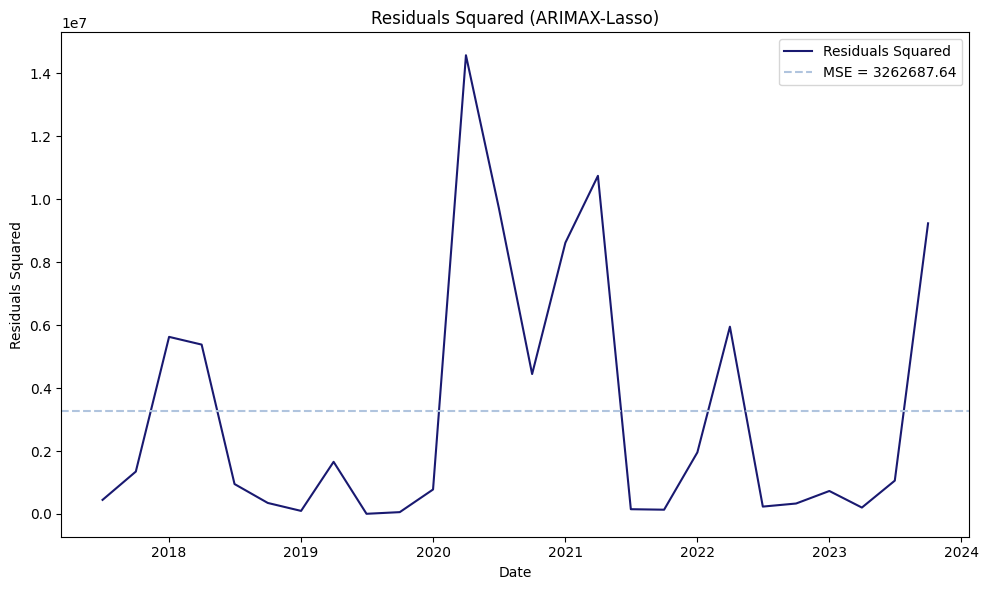

In [10]:
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(dates), residuals_squared, color = 'midnightblue', label = 'Residuals Squared')
plt.axhline(y = rmse**2, color ='lightsteelblue', linestyle ='--', label = f'MSE = {rmse**2:.2f}')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared (ARIMAX-Lasso)')
plt.legend()
plt.tight_layout()
plt.show()

```bash
In this Time-Series Lasso model, we predicted the quarterly change in the Dow Jones index (t) using macroeconomic indicators and the previous quarters change in Dow Jones (t−1). The response variable was differenced to ensure stationarity, and predictors were aligned so that all macro variables and the differenced Dow Jones value at t−1 served as inputs to predict t.

This formulation preserves the time structure of the data while using Lasso regression to select the most important predictors and apply regularization.

The model produced a Test RMSE of 1806.29, meaning the average error in predicting quarterly index changes was around 1806 points — relatively high, but expected given the volatility and magnitude of Dow movements.

Coefficient Interpretation:
GDP_Growth = 122.85: The strongest predictor in the model — prior GDP expansion is highly associated with increases in the Dow Jones.

M2_Supply = 65.18: Suggests that greater liquidity from the previous quarter helps boost market performance.

Unemployment_Rate = 27.29: Slightly positive, possibly reflecting delayed labor market improvements after equity markets recover.

Real_IR = −0.19: Small negative effect, consistent with the idea that higher real interest rates may slow investment.

CPI and Federal_Funds_Rate = 0.00: Not selected by Lasso, indicating minimal independent predictive value when accounting for other factors.

Dow_Jones_Diff (t−1) = 0.00: the previous quarter’s change in the Dow did not help predict the current one, suggesting less momentum or autocorrelation compared to other indices like the S&P 500.

This model highlights that while macroeconomic growth and liquidity were key drivers of change in the Dow Jones, past performance did not inform future change.
```

In [21]:
data = {
    'Model': ['MLR', 'Standard Lasso', 'ARIMAX-style Lasso'],
    'Test RMSE': [5969.81, 6101.33, 1806.29],
    'Optimal Lambda': ['N/A', 11.71, 40.56],
    'Top Predictors': [
        'M2_Supply, Unemployment_Rate',
        'M2_Supply, Unemployment_Rate, CPI',
        'M2_Supply, GDP_Growth, Unemployment_Rate'
    ],
    'Differenced Series': ['No', 'No', 'Yes']
}

comparison_df = pd.DataFrame(data)

comparison_df

,Model,Test RMSE,Optimal Lambda,Top Predictors,Differenced Series
0,MLR,5969.81,N/A,"M2_Supply, Unemployment_Rate",No
1,Standard Lasso,6101.33,11.71,"M2_Supply, Unemployment_Rate, CPI",No
2,ARIMAX-style Lasso,1806.29,40.56,"M2_Supply, GDP_Growth, Unemployment_Rate",Yes
